In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import redis


In [2]:
r = redis.Redis(host='127.0.0.1', port=6379, db=0)  # 根据你的配置调整

In [3]:
hash_list = r.keys('*')
# 哈希表中可能有多个字段，我们只获取温度和湿度
data_points = [r.hgetall(i) for i in hash_list]
sorted_hash_list = sorted(data_points, key=lambda x: x[b'Datetime'])
sorted_hash_list[:6]

[{b'Temperature': b'29.0',
  b'Humidity': b'47.0',
  b'Datetime': b'2024-04-27 23:34:39'},
 {b'Temperature': b'29.0',
  b'Humidity': b'43.0',
  b'Datetime': b'2024-04-27 23:34:43'},
 {b'Temperature': b'29.0',
  b'Humidity': b'58.0',
  b'Datetime': b'2024-04-27 23:34:45'},
 {b'Temperature': b'29.0',
  b'Humidity': b'63.0',
  b'Datetime': b'2024-04-27 23:34:48'},
 {b'Temperature': b'34',
  b'Humidity': b'50.0',
  b'Datetime': b'2024-04-27 23:34:51'},
 {b'Temperature': b'28.0',
  b'Humidity': b'49.0',
  b'Datetime': b'2024-04-27 23:34:53'}]

In [4]:
temperature = [float(dp[b'Temperature']) for dp in sorted_hash_list[:6]]
humidity = [float(dp[b'Humidity']) for dp in sorted_hash_list[:6]]

In [5]:
df = pd.DataFrame({
    'Temperature': temperature,
    'Humidity': humidity
})
df

,Temperature,Humidity
0,29.0,47.0
1,29.0,43.0
2,29.0,58.0
3,29.0,63.0
4,34.0,50.0
5,28.0,49.0


In [6]:
# data_mean = new_df[:].mean(axis=0)
# data_std = new_df[:].std(axis=0)
# features = (new_df - data_mean) / data_std

In [7]:
features = df
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

dataset = (dataset-data_mean)/data_std
dataset

array([[-0.3380617 , -0.68889496],
       [-0.3380617 , -1.27937636],
       [-0.3380617 ,  0.93492888],
       [-0.3380617 ,  1.67303063],
       [ 2.19740106, -0.24603392],
       [-0.84515425, -0.39365427]])

In [8]:
data = dataset.reshape(6, 2, 1, 1)

In [9]:
data.shape

(6, 2, 1, 1)

In [10]:
data

array([[[[-0.3380617 ]],

        [[-0.68889496]]],


       [[[-0.3380617 ]],

        [[-1.27937636]]],


       [[[-0.3380617 ]],

        [[ 0.93492888]]],


       [[[-0.3380617 ]],

        [[ 1.67303063]]],


       [[[ 2.19740106]],

        [[-0.24603392]]],


       [[[-0.84515425]],

        [[-0.39365427]]]])

In [11]:
data = data[np.newaxis,:,:,:,:]

In [12]:
data.shape

(1, 6, 2, 1, 1)

In [25]:
from tensorflow.python.keras.models import load_model

# load the checkpoint
checkpoint = tf.keras.models.load_model('./model/best_cnnLSTM2.h5')
checkpoint.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 6, 2, 1, 1)        4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 6, 2, 1, 64)       166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 2, 1, 64)       0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 6, 2, 1, 64)       256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 2, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 2, 1, 64)         

In [14]:
r = checkpoint.predict(data)
r.shape

(1, 6, 2, 1, 1)

In [15]:
res_data = np.squeeze(r)
res_data

array([[ 2.3583794, -2.3738747],
       [ 2.2822847, -2.3575895],
       [ 2.2757096, -2.3364222],
       [ 2.1916008, -2.3415563],
       [ 2.160973 , -2.3377287],
       [ 2.151291 , -2.3274646]], dtype=float32)

In [16]:
true_data = res_data*data_std + data_mean

In [17]:
from datetime import datetime, timedelta
# 获取当前时间
current_time = datetime.now()

# 生成6个间隔为10分钟的时间列表
time_list = [current_time + timedelta(minutes=10 * i) for i in range(6)]

def multi_step_output_plot(array, prediction):
    plt.figure(figsize=(18, 6))

    for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
        if prediction.any():
            print(np.array(prediction[:,i]))
            print(var.title())
            plt.plot(array, np.array(prediction[:,i]), markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")

    plt.legend(loc='upper left')
    plt.show()

[34.31745349 34.16739286 34.15442658 33.98856173 33.92816303 33.90906952]
Temperature
[35.58572204 35.69604004 35.83943001 35.80465089 35.83057938 35.90011016]
Humidity


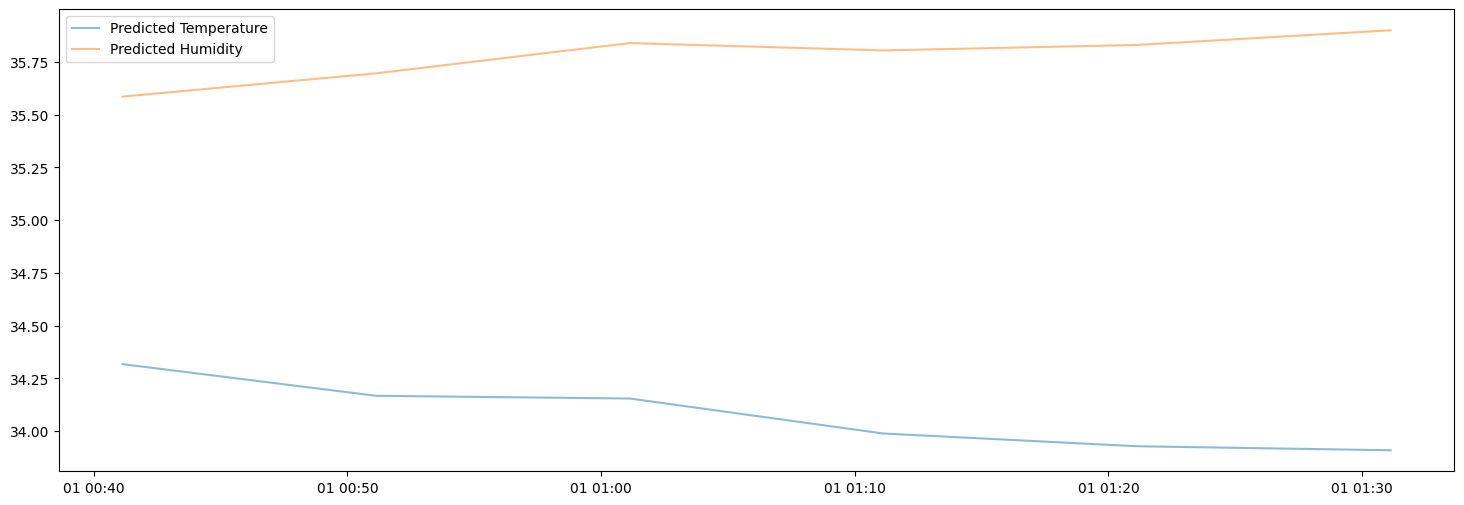

In [18]:
multi_step_output_plot(time_list, true_data)

In [23]:
true_data

array([[34.31745349, 35.58572204],
       [34.16739286, 35.69604004],
       [34.15442658, 35.83943001],
       [33.98856173, 35.80465089],
       [33.92816303, 35.83057938],
       [33.90906952, 35.90011016]])

In [24]:
np.array(true_data[:,1]).tolist()

[35.58572204018866,
 35.696040035726924,
 35.83943001127597,
 35.80465089238393,
 35.83057937639493,
 35.90011015782993]